<a href="https://colab.research.google.com/github/lebedevAU/N1/blob/main/%D0%94%D0%97_%D0%9E%D0%B1%D1%83%D1%87%D0%B0%D1%8E%D1%89%D0%B0%D1%8F_%D0%B8_%D1%82%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%B0%D1%8F_%D0%B2%D1%8B%D0%B1%D0%BE%D1%80%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Теоретический материал:* https://youtu.be/oPcBGVZ6aSU

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

# Оценка качества обучения нейронной сети в Keras

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=31

In [1]:
from tensorflow.keras.models import Sequential # НС прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras import utils # Утилиты для to_categorical
from tensorflow.keras.preprocessing import image # Для отрисовки изображения
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка изображений
from PIL import Image # Отрисовка изображений
import pandas as pd # Библиотека pandas
from google.colab import files # Импорт файлов
from sklearn.preprocessing import LabelEncoder, StandardScaler # Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline


##Загрузка файла

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=120

In [ ]:
# Загружаем файлы
files.upload()
!ls # Выводим содержимое корневой папки

## Загрузка данных

In [2]:
# Загружаем данные из файла sonar.csv
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
df = pd.read_csv("/content/drive/My Drive/sonar.csv", header=None)   # header=None, когда данные не имеют строки с заголовками
df.head()                                    # Выводим первые 5 строк наших данных

Mounted at /content/drive


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [3]:
print(df.shape) # Размерность данных

(208, 61)


In [3]:
dataset = df.values                 # Берем только значения массива(без индексов)
X = dataset[:,0:60].astype(float)   # Присваиваем им тип данных - float(с плавающей точкой) данным с 0 по 60 колонки
Y = dataset[:,60]                   # Присваеваем значению Y данные из столбца с индексом 60
Y[Y=='R']='0'                       # Если значение элемента столбца равно 'R', присваеваем ему значение '0'
Y[Y=='M']='1'                       # Если значение элемента столбца равно 'Y', присваеваем ему значение '1'
Y = Y.astype(int)                   # Меняем тип данных столбца на 'int'(целочисленный тип данных)
print(X.shape)                      # Выводим размерность X
print(Y.shape)                      # Выводим размерность Y
print(Y)                            

(208, 60)
(208,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Создание обучающей, проверочной и тестовой выборки

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=532

In [4]:
# sklearn - популярная библиотека для машинного обучения
# train_test_split - функция разделения на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import train_test_split


# test_size=0.2 - будет выделено 20% от тренировочных данных 
# shuffle=True - перемешать данные
# x_train - данные для обучения
# x_test - данные для проверки
# y_train - правильные ответы для обучения
# y_test - правильные ответы для проверки
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)    
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(166, 60)
(42, 60)
(166,)
(42,)


## Создание нейронной сети

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=751

In [20]:
# Функция пересоздаёт пустую сеть
def createModel():

  # Создаем сеть
  model = Sequential()

  # Добавляем слои
  #model.add(Dense(60, input_dim=60, activation='relu'))
  model.add(Dense(120, input_dim=60, activation='relu'))
  #model.add(Dropout(0.4, input_shape=(60,)))
  model.add(BatchNormalization())
  model.add(Dense(30,  activation='relu'))
  #model.add(Dropout(0.5, input_shape=(60,)))
  # 83%
  model.add(BatchNormalization())
  # 85% при нормализации на двух dense

  #model.add(BatchNormalization(axis=-1, momentum=0.99,epsilon=0.001, center=True, scale=True,))
  model.add(Dense(1, activation='sigmoid'))


  # Компилируем сеть
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

  return model # Возвращаем созданную сеть

### Варианты создания проверочной выборки

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=895


**validation_split**

**validation_data**

In [21]:
n_val = 40                  # Указываем 40 примеров в проверочную выборку
x_len = x_train.shape[0]    # Запоминаем размер всей выборки целиком
model = createModel()       # Создаём пустую сеть

# Обучаем сеть
model.fit(x_train[:x_len], # Берём все до индекса 166 - 40 = 126
          y_train[:x_len], 
          batch_size=8, 
          epochs=100,
          # Прямо указываем данные для проверочной выборки
          # Берём от индекса 126 до конца = 40 примеров
          validation_data=(x_train[x_len-n_val:], y_train[x_len-n_val:]), 
          verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
21/21 [==============================] - 1s 17ms/step - loss: 0.6397 - accuracy: 0.6386 - val_loss: 0.6523 - val_accuracy: 0.5750
Epoch 2/100
21/21 [==============================] - 0s 7ms/step - loss: 0.4019 - accuracy: 0.8133 - val_loss: 0.6310 - val_accuracy: 0.5750
Epoch 3/100
21/21 [==============================] - 0s 7ms/step - loss: 0.4327 - accuracy: 0.8012 - val_loss: 0.6180 - val_accuracy: 0.5750
Epoch 4/100
21/21 [==============================] - 0s 8ms/step - loss: 0.3099 - accuracy: 0.8976 - val_loss: 0.6060 - val_accuracy: 0.5750
Epoch 5/100
21/21 [==============================] - 0s 7ms/step - loss: 0.3077 - accuracy: 0.8735 - val_loss: 0.5815 - val_accuracy: 0.6750
Epoch 6/100
21/21 [==============================] - 0s 7ms/step - loss: 0.2582 - accuracy: 0.9277 - val_loss: 0.5629 - val_accuracy: 0.6250
Epoch 7/100
21/21 [==============================] - 0s 7ms/step - loss: 0.2451 - accuracy: 0.9157 - val_loss: 0.5136 - val_accuracy: 0.8500
Epoch 8/100


**sklearn train_test_split**

## Проверяем качество обучения на тестовом наборе данных

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=1542

In [22]:
# Вычисляем результаты сети на тестовом наборе
scores = model.evaluate(x_test, y_test, verbose=1)

# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print(scores)
print("Доля верных ответов на тестовых данных, в процентах: ", round(scores[1] * 100, 4), "%", sep="")

2/2 [==============================] - 0s 8ms/step - loss: 0.3126 - accuracy: 0.9048
[0.3125620186328888, 0.9047619104385376]
Доля верных ответов на тестовых данных, в процентах: 90.4762%


## Визуализация качества обучения

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=1683


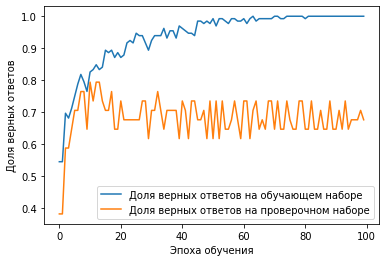

In [55]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

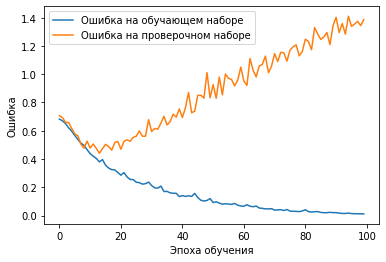

In [56]:
# Выводим графики ошибки
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Нормализация

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=2134

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.7275 - accuracy: 0.5227 - val_loss: 0.6774 - val_accuracy: 0.6765
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 0.6870 - accuracy: 0.5530 - val_loss: 0.6774 - val_accuracy: 0.7059
Epoch 3/100
1/1 [==============================] - 0s 29ms/step - loss: 0.6493 - accuracy: 0.5985 - val_loss: 0.6773 - val_accuracy: 0.7059
Epoch 4/100
1/1 [==============================] - 0s 26ms/step - loss: 0.6139 - accuracy: 0.6439 - val_loss: 0.6772 - val_accuracy: 0.7353
Epoch 5/100
1/1 [==============================] - 0s 34ms/step - loss: 0.5811 - accuracy: 0.6591 - val_loss: 0.6771 - val_accuracy: 0.7353
Epoch 6/100
1/1 [==============================] - 0s 28ms/step - loss: 0.5511 - accuracy: 0.6970 - val_loss: 0.6770 - val_accuracy: 0.7353
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 0.5234 - accuracy: 0.7348 - val_loss: 0.6769 - val_accuracy: 0.7353
Epoch 8/100
1/1 [=====

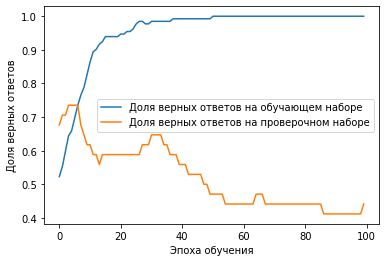

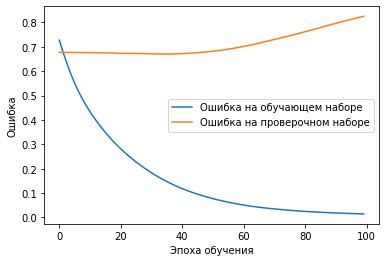

In [57]:
model = Sequential()

# Добавляем слой пакетной нормализации
# Теперь input_shape=(60, ) надо указывать в нём
# А не в первом полносвязном слое
model.add(BatchNormalization(input_shape=(60, )))
model.add(Dense(60, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

history = model.fit(x_train, 
                    y_train, 
                    batch_size=200, 
                    epochs=100,
                    validation_split=0.2,
                    verbose=1)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#Выводим графики ошибки
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/100
1/1 [==============================] - 0s 181ms/step - loss: 1.0839 - accuracy: 0.3939 - val_loss: 0.6784 - val_accuracy: 0.5882
Epoch 2/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0267 - accuracy: 0.4848 - val_loss: 0.6772 - val_accuracy: 0.5588
Epoch 3/100
1/1 [==============================] - 0s 24ms/step - loss: 0.9229 - accuracy: 0.4848 - val_loss: 0.6762 - val_accuracy: 0.6176
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 1.0738 - accuracy: 0.4242 - val_loss: 0.6753 - val_accuracy: 0.5882
Epoch 5/100
1/1 [==============================] - 0s 25ms/step - loss: 0.8044 - accuracy: 0.5455 - val_loss: 0.6743 - val_accuracy: 0.5588
Epoch 6/100
1/1 [==============================] - 0s 23ms/step - loss: 0.8772 - accuracy: 0.5682 - val_loss: 0.6735 - val_accuracy: 0.5588
Epoch 7/100
1/1 [==============================] - 0s 27ms/step - loss: 0.8145 - accuracy: 0.5530 - val_loss: 0.6729 - val_accuracy: 0.5294
Epoch 8/100
1/1 [==

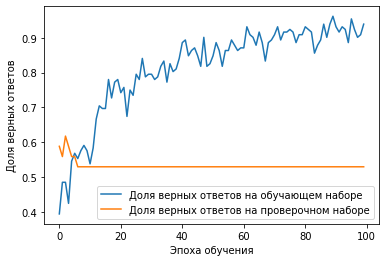

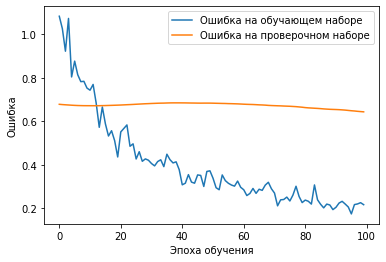

In [ ]:
model = Sequential()

# Добавляем слой пакетной нормализации
# Теперь input_shape=(784, ) надо указывать в нём
# А не в первом полносвязном слое
model.add(Dense(60, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(30, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

history = model.fit(x_train, 
                    y_train, 
                    batch_size=200, 
                    epochs=100,
                    validation_split=0.2,
                    verbose=1)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Выводим графики ошибки
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

# Предсказание цен машин с Юлы

*Разбор данного раздела:* https://youtu.be/ZNVupJXQisM?t=2386

In [ ]:
# Загружаем файлы
files.upload()
!ls # Выводим содержимое корневой папки

In [ ]:
# Считываем csv с помощью pandas
cars = pd.read_csv('cars_new.csv', sep=',')
cars[:5] # Выводим первые 5 машин 

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [ ]:
print(cars.values.shape)

In [ ]:
# Создаём словарь поле - его индекс
def create_dict(s):
  ret = {}                          # Создаём пустой словарь
  for _id, name in enumerate(s):    # Проходим по всем парам - id и название
    ret.update({name: _id})         # Добавляем в словарь
  return ret

# Функция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [ ]:
# Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

# Запоминаем цены
prices = np.array(cars['price'], dtype=np.float)

# Запоминаем числовые параметры
# и нормируем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

In [ ]:
print(marks_dict)

{'bmw': 0, 'mercedes-benz': 1, 'hyundai': 2, 'mitsubishi': 3, 'ford': 4, 'toyota': 5, 'daewoo': 6, 'renault': 7, 'mazda': 8, 'nissan': 9, 'chevrolet': 10, 'suzuki': 11, 'peugeot': 12, 'kia': 13, 'skoda': 14, 'audi': 15, 'subaru': 16, 'volkswagen': 17, 'honda': 18, 'chery': 19, 'opel': 20}


In [ ]:
years.mean()

7.129646144783743e-15

In [ ]:
years.std()

1.0

In [ ]:
print(powers)

[ 0.22905575 -0.95630346 -0.87163494 ...  0.22905575 -0.75309902
  2.34576862]


In [ ]:
# Создаём пустую обучающую выборку
x_train = []
y_train = []

# Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  # В y_train добавляем цену
  y_train.append(prices[_id])
  
  # В x_train объединяем все параметры
  # Категорийные параметры добавляем в виде ohe
  # Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  # Добавляем текущую строку в общий x_train
  x_train.append(x_tr)

# Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)

In [ ]:
# Выводим размеры выборок
print(x_train.shape)
print(y_train.shape)

(70119, 3208)
(70119,)


In [ ]:
# Выводим один x_train
print(x_train[0,:20])
print(x_train[0,-20:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          1.          1.5200145  -1.40018212
  0.12288486  0.22905575]


In [ ]:
# Выводим y_train
print(y_train[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]


In [ ]:
# Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

# y_train.reshape(-1,1) добавляет одну размерность
# Это нужно потому, что y_scaler.fit_transform
# Требует двумерны вектор, массив примеров, которые надо нормализовать
# Он не умеет работать с одним примеров
# Поэтому мы делаем массив из одного примера
# На выходе он так же выдаёт массив примеров
# Но нам нужен только первый пример
# Поэтому мы делаем flatten() - уменьшение размерности

In [ ]:
y_train_scaled.shape

(70119,)

In [ ]:
# Выводим базовый и нормированный y_train
print(y_train[:10])
print(y_train_scaled[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]
[ 0.75082432 -0.62135434  0.3563911   0.70913625 -0.51745486  0.73318706
  0.09824578 -0.04445567  1.27032173 -0.4132347 ]


In [ ]:
model_ula = Sequential()
model_ula.add(Dense(300, activation = 'relu', input_shape = x_train.shape[1:]))
model_ula.add(Dense(100, activation = 'relu'))
model_ula.add(Dense(1))
model_ula.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
# training
model_ula.fit(x_train, y_train_scaled, epochs = 20, batch_size = 32, validation_split = 0.1)

predict = model_ula.predict(x_test)


# Глоссарий

**Типы выборок:**

*   *Обучающая выборка* - основной набор данных, на котором происходит обучение нейронной сети
*   *Проверочная выборка* - набор данных, на котором отслеживается качество работы сети в процессе обучения
*   *Тестовая выборка* - контрольный набор данных, на котором проверяется качество работы обученной сети



**Способы формирования проверочной выборки:**


*   validation_split - указываем процент от обучающей выборки, который будет использоваться в качестве проверочной
*   validation_data - указываем готовые наборы данных, которые будут использоваться в качестве проверочной выборки

**Переобучение сети** - ситуация, при которой сеть "заучила" исходную обучающую выборку и не способна производить обобщение данных (верно распознавать данные из проверочных и тестовых наборов)

**Способы преодоления переобучения:**


*   Dropout - принудительное "отключение" случайного числа нейронов
*   BatchNormalization - нормализация данных на выходе слоя

**StandardScaler** - класс нормализации данных (приводит переданный набор числовых данных к нормальному распределению)

